# Abstract

Using the Black-Scholes model for call options, we can try to "predict" the price of options. The equation has a few underlying assumptions. One of the major assumptions is that q, the annual dividend yield is set to 0. Furthermore, we can define "moneyness" as M = K/S where K is the strike price and S is the price of the stock. With that in mind, the equation simplifies and shows that it now depends on moneyness, risk-free rate, volatility and time to maturity. Lastly, volatility isn't constant. We can try to derive the volatility based on the price of options that already exist. We can use the equation for volatility

$$\sigma (M, \tau) = \sigma_0 + \alpha \tau + \beta(M-1)^2$$

We can start by defining some of the parameters for the volatility (alpha, sigma, beta)

In [36]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import pickle
from scipy import stats
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 300

## Data preparation

In [13]:
data = pd.read_csv('SNP.csv', on_bad_lines='skip')

In [14]:
data

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,216.04,192.5,0.003445,0.0196,0.3191,0.0088,23.70
1,216.04,200.0,0.003445,0.0196,0.3191,0.0088,16.50
2,216.04,202.5,0.003445,0.0196,0.3191,0.0088,14.10
3,216.04,205.0,0.003445,0.0196,0.3191,0.0088,11.60
4,216.04,207.5,0.003445,0.0196,0.3191,0.0088,9.20
...,...,...,...,...,...,...,...
47253,83.28,85.0,1.957636,0.0415,0.4502,0.0088,15.00
47254,83.28,90.0,1.957636,0.0415,0.4502,0.0088,12.80
47255,83.28,95.0,1.957636,0.0415,0.4502,0.0088,11.10
47256,83.28,100.0,1.957636,0.0415,0.4502,0.0088,9.85


In [16]:
data['Stock Price'] = data['Stock Price']/ data['Strike Price']
data['Call Price'] = data['Call Price']/data['Strike Price']
data['Strike Price'] = data['Strike Price'] / data['Strike Price']

In [17]:
data

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,1.122286,1.0,0.003445,0.0196,0.3191,0.0088,0.123117
1,1.080200,1.0,0.003445,0.0196,0.3191,0.0088,0.082500
2,1.066864,1.0,0.003445,0.0196,0.3191,0.0088,0.069630
3,1.053854,1.0,0.003445,0.0196,0.3191,0.0088,0.056585
4,1.041157,1.0,0.003445,0.0196,0.3191,0.0088,0.044337
...,...,...,...,...,...,...,...
47253,0.979765,1.0,1.957636,0.0415,0.4502,0.0088,0.176471
47254,0.925333,1.0,1.957636,0.0415,0.4502,0.0088,0.142222
47255,0.876632,1.0,1.957636,0.0415,0.4502,0.0088,0.116842
47256,0.832800,1.0,1.957636,0.0415,0.4502,0.0088,0.098500


## Data Splitting

In [20]:
np.random.seed(0)
x_train, x_test, y_train, y_test = train_test_split(data.drop('Call Price', axis = 1), data['Call Price'], test_size = 0.2)

## Model Creation

The model that we'll follow will be based on a paper written by Robert Culkin and Sanjiv R. Das. The paper tried to recreate an MLP regressor proposed by Hutchinson. The model follows the following specifications.

- 4 hidden layers
- 100 neurons per layer
- The activation functions of LeakyReLU, ELU, ReLU, ELU respectively
- Batch size of 64
- Drop out rate of 25%
- 10 epochs

In [27]:
model = MLPRegressor(hidden_layer_sizes= (100, 100, 100, 100), solver= 'adam', shuffle= False, batch_size= 64, verbose = True, max_iter = 10)

In [28]:
model.fit(x_train, y_train)

Iteration 1, loss = 0.01248248
Iteration 2, loss = 0.00974039
Iteration 3, loss = 0.00946797
Iteration 4, loss = 0.00925737
Iteration 5, loss = 0.00914407
Iteration 6, loss = 0.00898423
Iteration 7, loss = 0.00868122
Iteration 8, loss = 0.00814324
Iteration 9, loss = 0.00790855
Iteration 10, loss = 0.00773983


/opt/anaconda3/envs/quant/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(batch_size=64, hidden_layer_sizes=(100, 100, 100, 100),
             max_iter=10, shuffle=False, verbose=True)

In [29]:
print(f"Training score: {model.score(x_train, y_train)}")

Training score: 0.8825264418042749


In [30]:
print(f"Testing score: {model.score(x_test, y_test)}")

Testing score: 0.8776515483636116


In [44]:
predicted = model.predict(x_train)
actual = y_train

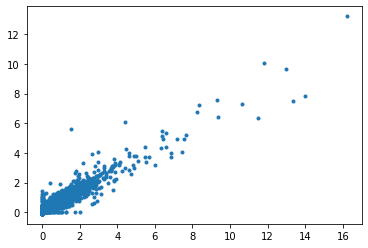

In [45]:
plt.plot(actual, predicted, '.')

## Using Tensorflow

Although sklearn makes creating an MLPRegressor relatively simple, it was hard finding the correct way of implementing specific activation functions as well as dropout rate. Using Tensorflow, it may be easier to have more control